In [1]:
import time
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

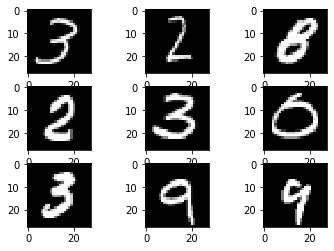

In [4]:
X, Y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.reshape((-1,1,28,28))
Y = Y.astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
plt.figure()
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i].reshape((28,28)),cmap='gray')
plt.show()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [5]:
train_data = TensorDataset(torch.from_numpy(X_train.astype(float)).view(-1,1,28,28).float(),torch.from_numpy(Y_train).type(torch.LongTensor))
test_data = TensorDataset(torch.from_numpy(X_test.astype(float)).view(-1,1,28,28).float(),torch.from_numpy(Y_test).type(torch.LongTensor))
val_data = TensorDataset(torch.from_numpy(X_val.astype(float)).view(-1,1,28,28).float(),torch.from_numpy(Y_val).type(torch.LongTensor))

In [54]:
torch.from_numpy(X_train.astype(float))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [40]:
mnist_transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

class CDataset(Dataset):
    def __init__(self, arrays, transform=None):
        assert all(arrays[0].shape[0] == array.shape[0] for array in arrays)
        self.arrays = arrays
        self.transform = transform
    def __getitem__(self, index):
        x = self.arrays[0][index]
        if self.transform:
            x = self.transform(x)
        y = self.arrays[1][index]
        return x, y 
    def __len__(self):
        return self.arrays[0].shape[0]

# X_train, Y_train, X_val, Y_val, X_test, Y_test = map(torch.from_numpy, (X_train, Y_train, X_val, Y_val, X_test, Y_test))
train_data = CDataset(arrays=(X_train,Y_train),transform = mnist_transform)
val_data = CDataset(arrays=(X_val, Y_val),transform = mnist_transform)
test_data = CDataset(arrays=(X_test, Y_test),transform = mnist_transform)

In [21]:
# inspired by MNIST example from pytorch.
class Conv_Net(nn.Module):
    def __init__(self):
        super(Conv_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

def train(model, device, train_loader, val_loader, optimizer, epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
#         if batch_idx % log_interval == 0:
    model.eval()
    with torch.no_grad():
        train_loss = 0
        train_correct = 0
        for train_batch_idx, (train_data, train_target) in enumerate(train_loader):
            train_data, train_target = train_data.to(device), train_target.to(device)
            train_output = model(train_data)
            train_loss += F.nll_loss(train_output, train_target, reduction='sum').item()
            train_pred = train_output.argmax(dim=1, keepdim=True)
            train_correct += train_pred.eq(train_target.view_as(train_pred)).sum().item()
        train_acc = 100. * train_correct / len(train_loader.dataset)
        train_loss /= len(train_loader.dataset)
        val_loss = 0
        val_correct = 0
        for val_batch_idx, (val_data, val_target) in enumerate(val_loader):
            val_data, val_target = val_data.to(device), val_target.to(device)
            val_output = model(val_data)
            val_loss += F.nll_loss(val_output, val_target, reduction='sum').item()
            val_pred = val_output.argmax(dim=1, keepdim=True)
            val_correct += val_pred.eq(val_target.view_as(val_pred)).sum().item()
        val_acc = 100. * val_correct / len(val_loader.dataset)
        val_loss /= len(val_loader.dataset)
    print('Train Epoch: {}\tTrain Avg Loss: {:.4f}\tTrain Acc: {:.0f}%\tVal Avg Loss: {:.4f}\tVal Acc: {:.0f}%'.format(
        epoch, train_loss, train_acc,val_loss,val_acc))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [22]:
batch_size = 64 # batch size
test_batch_size = 1000 # testing batch size
epochs = 20 # number of training epochs
lr = 1 # learning rate
gamma = 0.7 # lr decay
seed = 42 
log_interval = 5
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
transform_kwargs = {}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
torch.manual_seed(seed)

train_loader = DataLoader(train_data,**train_kwargs)
val_loader = DataLoader(val_data,**test_kwargs)
test_loader = DataLoader(test_data, **test_kwargs)

model = Conv_Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, val_loader, optimizer, epoch)
    scheduler.step()
test(model, device, test_loader)

Train Epoch: 1	Train Avg Loss: 0.0487	Train Acc: 98%	Val Avg Loss: 0.0612	Val Acc: 98%
Train Epoch: 2	Train Avg Loss: 0.0330	Train Acc: 99%	Val Avg Loss: 0.0557	Val Acc: 98%
Train Epoch: 3	Train Avg Loss: 0.0222	Train Acc: 99%	Val Avg Loss: 0.0481	Val Acc: 99%
Train Epoch: 4	Train Avg Loss: 0.0183	Train Acc: 99%	Val Avg Loss: 0.0444	Val Acc: 99%
Train Epoch: 5	Train Avg Loss: 0.0144	Train Acc: 100%	Val Avg Loss: 0.0419	Val Acc: 99%
Train Epoch: 6	Train Avg Loss: 0.0127	Train Acc: 100%	Val Avg Loss: 0.0415	Val Acc: 99%
Train Epoch: 7	Train Avg Loss: 0.0118	Train Acc: 100%	Val Avg Loss: 0.0416	Val Acc: 99%
Train Epoch: 8	Train Avg Loss: 0.0111	Train Acc: 100%	Val Avg Loss: 0.0428	Val Acc: 99%
Train Epoch: 9	Train Avg Loss: 0.0103	Train Acc: 100%	Val Avg Loss: 0.0410	Val Acc: 99%
Train Epoch: 10	Train Avg Loss: 0.0100	Train Acc: 100%	Val Avg Loss: 0.0410	Val Acc: 99%
Train Epoch: 11	Train Avg Loss: 0.0095	Train Acc: 100%	Val Avg Loss: 0.0403	Val Acc: 99%
Train Epoch: 12	Train Avg Loss: 0.